In [162]:
import torch
import matplotlib.pyplot as plt
import random

# Database description

In [163]:
PATH_ES = 'datasets/traductor-spanish/Tatoeba.en-es.es'
PATH_EN = 'datasets/traductor-spanish/Tatoeba.en-es.en'

In [164]:
eng_sentences = []
spa_sentences = []

In [165]:
with open(PATH_EN, 'r', encoding='utf-8') as f:
    for line in f:
        eng_sentences.append(line.strip())

with open(PATH_ES, 'r', encoding='utf-8') as f:
    for line in f:
        spa_sentences.append(line.strip())

assert len(eng_sentences) == len(spa_sentences), "The number of sentences in both files must be the same."

## Sample Database

In [166]:
for i in range(5):
    idx = random.randint(0, len(eng_sentences) - 1)
    print(f"{idx} English: {eng_sentences[idx]}")
    print(f"{idx} Spanish: {spa_sentences[idx]}")
    print()
print(f"Number of sentences: {len(eng_sentences)}")

105937 English: How did you spend your summer holiday?
105937 Spanish: ¿Cómo pasaste las vacaciones de verano?

60314 English: Hearing the sad news, she collapsed in tears.
60314 Spanish: Después de oír la triste noticia, se puso a llorar.

155560 English: You don't know my brother.
155560 Spanish: No conocen a mi hermano.

53487 English: He went to bed.
53487 Spanish: Él se fue a acostar.

147909 English: You're too little.
147909 Spanish: Eres demasiado pequeño.

Number of sentences: 222073


# Database preprocessing

In [183]:
from transformers import AutoTokenizer
from transformers import logging
logging.set_verbosity_error()

In [168]:
# Cargar el tokenizador de BERT (puedes usar otro modelo)
tokenizer_en = AutoTokenizer.from_pretrained("t5-small")
tokenizer_es = AutoTokenizer.from_pretrained("google/mt5-small")


for i in range(len(eng_sentences)):
    eng_sentences[i] = tokenizer_en.tokenize(eng_sentences[i])
    spa_sentences[i] = tokenizer_es.tokenize(spa_sentences[i])

for i in range(5):
    idx = random.randint(0, len(eng_sentences) - 1)
    print(f"{idx} English: {eng_sentences[idx]}")
    print(f"{idx} Spanish: {spa_sentences[idx]}")


/home/juangomez/entorno_NLP/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


15537 English: ['▁It', '▁was', '▁about', '▁the', '▁size', '▁of', '▁an', '▁egg', '.']
15537 Spanish: ['▁Era', '▁más', '▁', 'o', '▁menos', '▁del', '▁porte', '▁de', '▁un', '▁hu', 'evo', '.']
59248 English: ['▁She', '▁looks', '▁at', '▁least', '▁sixty', '.']
59248 Spanish: ['▁Pare', 'ce', '▁', 'tener', '▁al', '▁menos', '▁ses', 'enta', '▁años', '.']
69379 English: ['▁He', '▁needs', '▁', 'a', '▁medication', '▁but', '▁doesn', '’', 't', '▁want', '▁it', '.']
69379 Spanish: ['▁Él', '▁necesita', '▁medic', 'ación', ',', '▁pero', '▁no', '▁la', '▁', 'quiere', '.']
28314 English: ['▁When', '▁I', '▁looked', '▁about', ',', '▁I', '▁found', '▁', 'a', '▁letter', '▁on', '▁the', '▁desk', '.']
28314 Spanish: ['▁', 'Cuando', '▁mir', 'é', '▁', 'a', '▁mi', '▁al', 're', 'dedor', ',', '▁vi', '▁una', '▁carta', '▁sobre', '▁el', '▁escrit', 'orio', '.']
64612 English: ['▁She', "'", 's', '▁un', 'fit', '▁for', '▁the', '▁job', '.']
64612 Spanish: ['▁Ella', '▁es', '▁in', 'adec', 'uada', '▁para', '▁el', '▁trabajo', '.']


In [169]:
max_len_sentence = 0
for i in range(len(eng_sentences)):
    if len(eng_sentences[i]) > max_len_sentence:
        max_len_sentence = len(eng_sentences[i])
print(f"Max length sentence: {max_len_sentence}")

Max length sentence: 307


# Create Dataloader

In [170]:
def build_vocab(sentences):
    tokens = [token for sentence in sentences for token in sentence]
    dict_tokens = {}
    for token in tokens:
        if token not in dict_tokens:
            dict_tokens[token] = 1
        else :
            dict_tokens[token] += 1
    
    sorted_tokens = sorted(dict_tokens.items(), key = lambda x: x[1], reverse=True)

    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_tokens, 2)}
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    idx2word = {idx: word for word, idx in word2idx.items()}


    return word2idx, idx2word
    
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)

In [171]:
print(len(eng_word2idx))
print(len(spa_word2idx))


17324
19847


In [172]:
for key, value in list(eng_word2idx.items())[:10]:
  print(f'{key}: {value}')

.: 2
▁: 3
▁I: 4
': 5
▁the: 6
▁to: 7
a: 8
s: 9
▁you: 10
▁is: 11


In [195]:
from torch.utils.data import Dataset, DataLoader

class eng2esDataset(Dataset):
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        self.eng_sentences = eng_sentences
        self.spa_sentences = spa_sentences
        self.eng_word2idx = eng_word2idx
        self.spa_word2idx = spa_word2idx

    def __len__(self):
        assert len(self.eng_sentences) == len(self.spa_sentences), "Mismatch in the number of sentences"
        return len(self.eng_sentences)

    def __getitem__(self, idx):
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]

        # Ahora eng_sentence y spa_sentence ya son listas de tokens
        eng_idx = [self.eng_word2idx.get(token, self.eng_word2idx['<unk>']) for token in eng_sentence]
        spa_idx = [self.spa_word2idx.get(token, self.spa_word2idx['<unk>']) for token in spa_sentence]

        return torch.tensor(eng_idx, dtype=torch.uint16), torch.tensor(spa_idx, dtype = torch.uint16)

In [196]:
from torch.nn.utils.rnn import pad_sequence

MAX_LEN = 128

def collate_fn(batch):
    eng_batch, spa_batch = zip(*batch)

    eng_batch = [seq[:MAX_LEN] for seq in eng_batch]
    spa_batch = [seq[:MAX_LEN] for seq in spa_batch]

    eng_batch_pad = pad_sequence(eng_batch,  batch_first= True, padding_value=0)
    spa_batch_pad = pad_sequence(spa_batch,  batch_first= True, padding_value=0)

    return eng_batch_pad, spa_batch_pad

In [197]:
dataset = eng2esDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [198]:
for batch in dataloader:
    eng_batch, spa_batch = batch
    print("English batch shape:", eng_batch.shape)
    print("Spanish batch shape:", spa_batch.shape)

    print("English batch:", eng_batch[0])
    print("Spanish batch:", spa_batch[0])
    break 

English batch shape: torch.Size([32, 18])
Spanish batch shape: torch.Size([32, 26])
English batch: tensor([  4,  23, 114, 394,  10,  17, 306,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0], dtype=torch.uint16)
Spanish batch: tensor([ 20,  48, 189, 887,  35,   2, 236,   4,  10, 393,   3,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=torch.uint16)


In [199]:
class NoamOptSchedule:
    def __init__(self, d_model, warmup_steps, step_num, optimizer):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = step_num
        self.optimizer = optimizer
        self._rate = 0
        self._step = 0
    
    def step(self):
        self._step += 1
        self._rate = self.rate()

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self._rate

    def rate(self):
        return self.d_model ** -0.5 * min(self._step ** -0.5, self._step * self.warmup_steps ** -1.5)
    
    def plot_learning_rate(self):
        x = np.arange(1, self.step_num + 1)
        y = [self.rate() for _ in range(self.step_num)]

        plt.plot(x, y)
        plt.xlabel('Step')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.show()

In [181]:
model = torch.nn.Transformer(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6)

/home/juangomez/entorno_NLP/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [182]:
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamOptSchedule(model_size=512, factor=1, warmup=4000, optimizer=optimizer)

TypeError: NoamOptSchedule.__init__() got an unexpected keyword argument 'model_size'

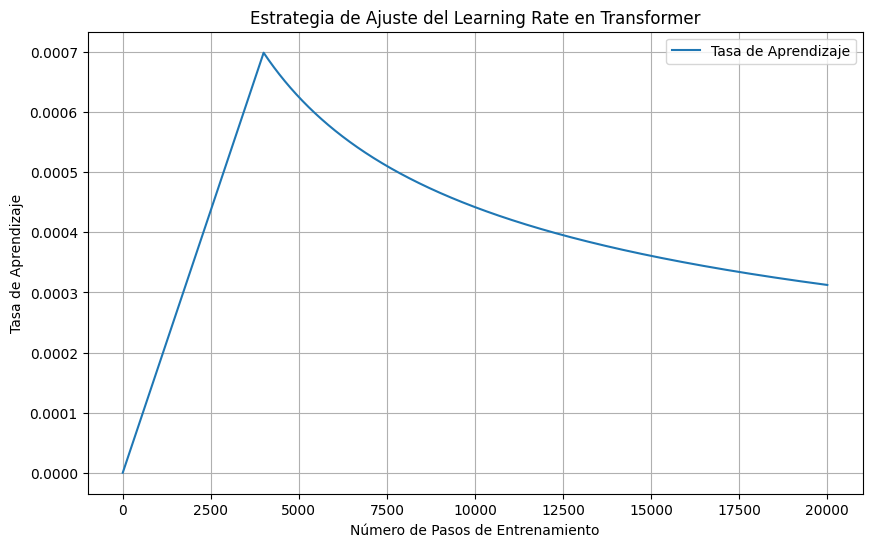

In [179]:
import matplotlib.pyplot as plt
import numpy as np

# Parámetros
d_model = 512
warmup_steps = 4000
total_steps = 20000

# Función de ajuste del learning rate
def lr_schedule(step_num, d_model, warmup_steps):
    step_num = np.asarray(step_num)  # Asegurarse de que step_num sea un arreglo de NumPy
    return d_model**-0.5 * np.minimum(step_num**-0.5, step_num * warmup_steps**-1.5)

# Generar pasos y tasas de aprendizaje
steps = np.arange(1, total_steps + 1)
lrs = lr_schedule(steps, d_model, warmup_steps)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(steps, lrs, label='Tasa de Aprendizaje')
plt.title('Estrategia de Ajuste del Learning Rate en Transformer')
plt.xlabel('Número de Pasos de Entrenamiento')
plt.ylabel('Tasa de Aprendizaje')
plt.grid(True)
plt.legend()
plt.show()

